<a href="https://colab.research.google.com/github/rajkstats/uplimit_langchain/blob/main/%5BRK%5D_Langchain_Week1_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is part of the course: [LLM Apps with Langchain](https://uplimit.com/course/llm-apps-with-langchain) and is created by Sidharth Ramachandran as the project for Week 1 of the course.

# Let's build "PillPal" - a Telegram bot and website that allows users to ask questions based on the Patient Information Leaflet (PIL) or drug guide that comes with any medication.

![Package Information Leaflet](https://i.ibb.co/ZSdGyjV/ima-image-36904.jpg)

I'm sure you have all come across the thin piece of folded paper that is part of every drug prescription box. Usually the text is in very small print and typically provides information about dosages, side effects, storage instructions and much more. They are hard to read and understand and requires some effort to get answers to common questions a patient might have. What if we could create a product that answers these questions and actually makes the medical information more accessible and easier to understand - enter PillPal!

In the process of building PillPal, we will go through the following stages and on the way learn more about LLM Apps and their typical life-cycle.

1. BUILD the app: this is where we first test the idea, try multiple options for various parts of the pipeline till we are satisfied to a reasonable extent that the product works.
2. DEPLOY & MONITOR the app: this is where we want to make the app available to our first users, monitor it's behaviour and discover edge cases.
3. EVALUATE & IMPROVE the app: this is the final and ongoing stage where we will build an evaluation suite that constantly checks whether our app is working as expected and perform experiments.

We will use Langchain to develop the app, deploy it as a Telegram bot/ Website and use Langsmith to monitor, evaluate and improve the product. Please consider PillPal as the chosen example/ case study to illustrate the process but feel free to adapt this project ot build any app of your choice!

# # 👨‍🎓 Learner Project

In the project walkthrough session we will go through the various steps of the project with an example of one of the drugs. The learner project is to implement the same steps for a different drug OR any other PDF of your choice. Concretely, here are steps that you need to do:

1. Identify a PDF that you would like to ask questions about. Suggestion: choose another drug or medication that you are familiar with.
2. Upload and use that PDF as you go through this notebook.
3. Make use of the sections and flow as a guide but you are expected to update and write code to complete the RAG project for your PDF.
4. Feel free to adapt any sections to add more functionality or adapt for your use case/ PDF.

# Step 0: Necessary libraries and setup

In [1]:
# Install the necessary libraries to get it out of the way
%pip install --upgrade --quiet  langchain langchain-community langchainhub langchain-openai langchain-chroma faiss-gpu pymupdf grandalf gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.6/990.6 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.6/318.6 kB 17.0 MB/s eta 0:00:

### OpenAI Initialization

Please create an account with [OpenAI](https://platform.openai.com/) that will allow us to access the API by visiting this link and creating an account with a method of your choice. Once created, please create a new project which you can call "Uplimit_Langchain_Course" as shown.
![Create Project](https://i.ibb.co/r7T2dxM/Xnapper-2024-06-09-21-37-03.png)
![Name Project](https://i.ibb.co/MS716LN/Xnapper-2024-06-09-21-37-56.png)

Once you have created the new project, please navigate to the API keys tab and then generate an API key for the Week1 project. It is helpful to track API keys seperately and you can revoke a given API key when not in use. Please copy the API key when you see it, we will use it in the next step and it will only be shown once to you in the Web interface.

![Create API Key](https://i.ibb.co/HpvCQmZ/Xnapper-2024-06-09-21-38-55.png)
![Copy API Key](https://i.ibb.co/TbRfGpH/Xnapper-2024-06-09-21-39-46.png)


You have now created the API key and you can add it to the Google Colab instance by adding it to the Secrets section as shown below. Please use the variable name 'OPENAI_API_KEY' and paste the value that you copied before.

![Add to Google Colab](https://i.ibb.co/Cb57Sxq/Xnapper-2024-06-09-21-42-30.png)

# Step 1: Building the PillPal bot

The patient information leaflets/ drug booklets are typically available in the form of PDFs from the drug manufacturers website or from a central repository like in the [UK](https://www.medicines.org.uk/) or the [US](https://dailymed.nlm.nih.gov/). While you should be able to find them relatively easily through an Internet Search, we also include the medical booklet PDFs for two drugs with this code repository to use in the project.

One of the best aspects of using Langchain is that it provides a lot of in-built integrations for most common development tasks while building LLM apps. We will make use of several of them during this project, starting with the PDF loader which we will use to read in the medical booklet PDF file. For this example, we have chosen the PIL for Ozempic - a new drug that decreses the risk of heart disease in overweight patients but has been in the news recently for also being a weight loss solution.

As we are still in the notebook environment - please follow the below steps to upload the PDF document into the Colab environment.

![Upload PDF](https://i.ibb.co/jgDBwY4/Xnapper-2024-06-09-21-58-08.png)

## 📝 Learner Task:

In the following section, you have to load in your PDF using any of the document loaders available from the Langchain Community package. For example: you could use the `PyMuPDFLoader` for managing PDFs.

Your code should do the following:
- Load the PDF
- Identify the number of pages
- Print one of the pages with the associated metadata

In [3]:
from langchain_community.document_loaders import PyMuPDFLoader

loader = PyMuPDFLoader("/content/pil.3474.pdf")
data = loader.load()
print ("The PDF document contains ", len(data), " pages")

The PDF document contains  3  pages


The additional metadata like page number and title is relevant to our product because when we answer questions: we can also point users to specific sections of the original document which they can refer to for more clarity.

Our next step is to index this entire document which we do with the help of OpenAI embeddings. However, before we do that we need to split document into chunks so that at the time of retrieval we are identifying the correct parts of the document. We use one of the in-built Langchain components that allows us to split based on characters based on our specifications.

We have chosen to split the entire document into chunks of length 2000 characters and also ensure an overlap of 200 characters. This makes sure that we are not loosing any information when splitting up the document. As we will see later, this is one of the parameters that we can control and could have an influence on the performance of our product.

## 📝 Learner Task:

In the following section, you have to decide the best chunking strategy for your PDF and use case. For instance, you could make use of the `RecursiveCharacterTextSplitter` to work with text documents. It's important to also decide what are reasonable values for `chunk_size` and `chunk_overlap`. In the project walkthrough we provide some suggested values.

In [4]:
import os
import openai
from getpass import getpass

openai.api_key = getpass("OpenAI API Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key

OpenAI API Key: ··········


In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Split leaflet into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap  = 100
)

split_drug_docs = text_splitter.split_documents(data)

In [6]:
# Get the total number of split documents
total_docs = len(split_drug_docs)
print("Total number of documents: ", total_docs)

Total number of documents:  14


We are optimising for retrieval - i.e. how fine-grained is the context that we can retrieve so that we can answer the question that our user is asking. In this case, it might be better to have a smaller chunk because you are then narrowing down on the perfect part of the text where this information is present.

A huge advantage of using Langchain is that it provides integrations with several types of vector databases like Chroma, Pinecone and more. In this project, we make use of the FAISS library from Facebook/Meta as a simple choice. In the following section, we combine the steps of generating the embedding value for each document chunk and then also storing it into the FAISS vector database.

In [7]:
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAI, OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
vector_store = FAISS.from_documents(documents=split_drug_docs, embedding=embedding_model)

We have our documents indexed and we can directly start retrieving documents based on a similarity search with a target query.

In [8]:
search_result = vector_store.similarity_search_with_relevance_scores(query="What is the recommended dosage?", k=4)
search_result

[(Document(metadata={'source': '/content/pil.3474.pdf', 'file_path': '/content/pil.3474.pdf', 'page': 1, 'total_pages': 3, 'format': 'PDF 1.6', 'title': 'PACKAGE LEAFLET: INFORMATION FOR THE', 'author': 'Wendy Horne', 'subject': '', 'keywords': '', 'creator': 'Acrobat PDFMaker 23 for Word', 'producer': 'Adobe PDF Library 23.8.234', 'creationDate': 'D:20240115085923Z', 'modDate': 'D:20240115085928Z', 'trapped': ''}, page_content='Adults, elderly patients and children 12 years and over: The recommended dose is \n10 mg once daily as one tablet daily. If the tablets make you feel drowsy or dizzy, \ntaking half a tablet twice a day may be better than taking one tablet once a day.  \nOther form(s) of this medicine may be more suitable for children; ask your doctor or \npharmacist. \nChildren aged 6 to 12 years: Half a tablet twice daily. \nChildren under 6 years: Not recommended.  \nPatients with renal impairment: Patients with moderate renal impairment are \nrecommended to take 5 mg once da

In this case, we have chosen to use cosine similarity as our distance metric and the similarity values are also shown along with the retrieved results. You will notice that not many of the retrieved chunks actually contain the text "Weight Loss" - and this is because we are not doing a word-based search but rather semantic search. This is what vector databases allow us to do. However, it is also possible that at times we want to match exact query terms and then we will follow a hybrid search approach. This is again one of the levers that we have to expriment with to determine what is necessary for our product. So it's important that you are able to determine what is the best method for you to choose - depends a lot on your use-case.

### Creating the QnA RAG chain

Let's move on to complete our product by integrating with the LLM. Here again, we rely heavily on the building blocks that Langchain already provides us to put together the entire chain.

The chain consists of multiple parts - a Retriever, followed by a Prompt Template where the retrieved documents are added and then the call to the LLM. The response from the LLM is what we finally show as output to the user. There are multiple steps in creating a RAG application. We break it down to make it easier to understand and follow.

## 📝 Learner Task:
Creating the Prompt Template. In the section below, please create the PromptTemplate that will be used for your RAG application. The `ChatPromptTemplate` has become the standardized way to use chat-based LLMs and consists of a `SystemMessage`, followed by the `HumanMessage` with the response from the LLM stored in the `AIMessage`. We have provided the necessary imports in the below cell and request you to create the variable `qna_prompt_template` that will be used in the application.

In [9]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import SystemMessagePromptTemplate
from langchain.prompts import HumanMessagePromptTemplate

qna_prompt = """
You are an AI assistant for reading information from medicine leaflets and you explain things in simple manner for a human to understand

If you don't know the answer, simply state that you don't have enough information to provide an answer. Do not attempt to make up an answer.

If the user greets you with a greeting like "Hi", "Hello", or "How are you", respond in a friendly manner.

Use the following pieces of context to answer the user's question
question: {question}
context : {context}
Answer:
"""

# Define messages for the chatbot prompt
messages = [
    SystemMessagePromptTemplate.from_template("You're a helpful AI assistant"),
    HumanMessagePromptTemplate.from_template(qna_prompt),
]

qna_prompt_template = ChatPromptTemplate.from_messages(messages)

After the PromptTemplate, the next step is to define the LLM Model that you would like to run with. We provide the OpenAI API models as the default option and in this case have selected `gpt-3.5-turbo`. Feel free to choose a different model, for e.g. the newly launched `gpt-4o-mini` if you would like to change it. We also set the `temperature` value to 0 as we do not want the model to be creative but rather answer based on the retrieved context from the PDF.

In [10]:
from langchain_community.chat_models import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-3.5-turbo",
                 temperature=0,
                 openai_api_key=openai.api_key)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


The next step is to initilize the retriever part of our application that will fetch the relevant documents from the PDF. Recall that we have already created the embeddings for our document chunks and stored it using the FAISS vectorstore. In this step, we only specify that vectorestore to be our retriever.

In [11]:
retriever = vector_store.as_retriever()

One additional step that we need to also consider is that when the documents are retrieved from the FAISS vectorstore, they are in the form of a list of documents. These document objects contain a lot more information other than the content like Metadata. Assuming we are performing a simple retrieval, the context that we want to pass to the LLM is only the text content. Therefore we write an additional function that combines only the retrieved text content that can be used to pass in the context of our PromptTemplate.

Please note that you could also choose to filter the retrieved documents based on the Metadata. For instance, if you only want to see results from Page 5 and beyond of the PDF - then you can also adapt this function to reflect that.

In [12]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

The final stage is to put together the various elements that we have defined above to create our pipeline. The key aspect to note here is that the input question is used twice during the process -> at the first instance to retrieve a list of the relevant context and the second instance when it is passed to the LLM as the question that needs to be answered.

So we make use of the `itemgetter` to retrieve the content of the question and pass to the retriever to get the relevant context. On the other hand, we make use of the `RunnablePassthrough` class to directly pass the input question to the subsequent operation. At the end we also add the `StrOuputParser` to get the actual text message of the response rather than the whole AIMessage.

In [13]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

rag_chain = (
    {"context": itemgetter("input") | retriever | format_docs,
     "question": RunnablePassthrough()}
    | qna_prompt_template
    | llm
    | StrOutputParser()
)

Please check that your entire chain works by providing your questions and invoking the RAG chain.

In [14]:
question = "Can Children be given this tablet?"
rag_chain.invoke({"input": question})

"Children under 6 years old should not be given this tablet. For children aged 6 to 12 years, the recommended dose is half a tablet twice daily. It's important to consult with a doctor or pharmacist for children's medication suitability and dosing adjustments."

## 📝 Learner Task:
If you run into errors as you develop, visualizing the chain is an easy way to discover any issues. This visualization helps us understand the entire flow of operations within our application. By graphically representing the connections and interactions between different components we can see how the data flows and in which shape from one path tothe next. It allows for easier debugging and we might be able to pinpoint where modifications might be necessary.

In [15]:
print (rag_chain.get_graph().print_ascii())

           +---------------------------------+        
           | Parallel<context,question>Input |        
           +---------------------------------+        
                    **              ***               
                 ***                   **             
               **                        ***          
       +--------+                           **        
       | Lambda |                            *        
       +--------+                            *        
            *                                *        
            *                                *        
            *                                *        
+----------------------+                     *        
| VectorStoreRetriever |                     *        
+----------------------+                     *        
            *                                *        
            *                                *        
            *                                *        
    +-----


Hopefully, you have managed to build the skeleton for your product. At first just make sure that everything is working in an end to end fashion. After you have achieved that you can move in the direction of improving the answers from the application. This is when you can start experimenting with different aspects of your pipeline to go in the direction of a better solution.

We would recommend adapting the following options:

- Chunk size:
- Retrieval strategy/ metric:
- Choice of LLM:

At the end of this stage, you should be able to have a working prototype of your solution that does reasonably well for the use-case you have in mind.

We are still relying on a vibe/gut-feel for the product and cannot rely on quantified metrics. But hopefully you can feel reasonably confident to launch an alpha version of your product to a select group of customers.

# Step 2: Deploying the PillPal bot

Before deploying our product, one of the important steps is to enable tracking and monitoring all the user queries and LLM responses. This is made very easy for us with the help of Langsmith - another part of the Langchain ecosystem.

This is one of the cornerstones of our strategy to get towards a more valuable and performing LLM app.

Please sign-up on the Langsmith [Website](https://smith.langchain.com/) and you should have access. Next, please navigate to the Settings page from the left side navigation menu and then create your API key there and copy it.

<a href="https://ibb.co/fN8s3Yp"><img src="https://i.ibb.co/ZgH0Q68/Screenshot-2024-07-26-at-16-12-48.png" alt="Screenshot-2024-07-26-at-16-12-48" border="0"></a>




After that, you can return to the main page and click the New Project icon and copy the environment details that you see.

<a href="https://ibb.co/th2CQhd"><img src="https://i.ibb.co/yRksdR3/Screenshot-2024-07-26-at-16-12-59.png" alt="Screenshot-2024-07-26-at-16-12-59" border="0"></a>

In [16]:
import os
from uuid import uuid4
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = f"Uplimit - PillPal - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass("LangSmith API Key: ")

LangSmith API Key: ··········


We can deploy our LLM app in two different ways -

1. A website based chatbot experience - this will be done with the help of Gradio and you do not need to leave the Colab notebook environment
2. A telegram chatbot that will run on Github Codespaces (or locally) and will need you to leave the Colab environment

### Deployed as website chatbot

We can deploy our QnA bot on a dedicated website using Gradio, an easy-to-use library for creating interactive machine learning interfaces. One significant advantage of using Gradio in our project is that it integrates seamlessly within the Colab notebook environment. This means you don't need to leave Colab to see your bot in action; you can run it directly from the notebook. Gradio also provides a dedicated URL that you can share with potential beta testers of the QnA bot to get feedback.

In [17]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import AIMessage, HumanMessage
import openai
import gradio as gr

def predict(message, history):
    return rag_chain.invoke({"input":message})

gr.ChatInterface(predict).launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://904123459e596474be.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


### [OPTIONAL] Deployed as Telegram bot

For a wider launch of your LLM app, you can easily make it available as a bot on Telegram - a messenger platform that is used by 500 million users every day. This is useful in the beta/alpha phase because it's way easier to get users to try it in an app that they already use every day. This need not be just Telegram but other popular messengers like Whatsapp, Signal etc. We chose Telegram as it's free and easy to setup.

In order to deploy using this option, we will make use of Github codespaces as it's difficult to run it within a synchronous coding environment like Colab. The instructions and code for this will be provided in the live project session.

Please go to the Github repository: https://github.com/sidhusmart/uplimit_langchain.git and clone it so that you can work on it directly. Please note that code in this repository may change frequently so we request you to work only on your cloned version.

Once you have cloned it, then you can launch your own Codespaces instance by following the steps as shown in the screenshot. This creates a virtual Visual Studio Code environment in the cloud where we can test our Telegram bot.

<a href="https://ibb.co/p02fJ1t"><img src="https://i.ibb.co/BzLyqfX/Screenshot-2024-07-26-at-16-05-46.png" alt="Screenshot-2024-07-26-at-16-05-46" border="0"></a>

The two important files for you to take a look are `langchain_rag_app.py` and `telegram_response_bot.py` The first python file contains the same RAG functionality that we already built but packaged in functions. The telegram response bot contains the necessary code required to run the Telegram bot.

There are two parameters that we must provide before we can run our bot. The first is the OPENAI_API_KEY. You can obtain this using the same steps that we already followed previously.

In order to get the Telegram bot API key, you need to follow these steps:

1. You must have a Telegram account and access to the App - Web or Mobile versions would also work.
2. On the Telegram app, you need to search and look for a contact called the Botfather.
3. You can use the `/start` command to get a list of options or directly use the `/newbot` command to create a new bot for yourself.
4. Then answer the set of questions by providing a name for and username for your bot.
5. At the end you will be provided with an API token that you can use to work with the bot. This API token is what we need to replace in the `telegram_response_bot.py` file.

<a href="https://imgbb.com/"><img src="https://i.ibb.co/f2MqxCd/Screenshot-2024-07-26-at-14-23-02.png" alt="Screenshot-2024-07-26-at-14-23-02" border="0"></a>

Once you have performed both these steps, you are now ready to run your RAG app as a Telegam bot. You need to run the command `python Week1/telegram_response_bot.py ` from the command line of your Github Space and this starts a thread that listens for messages on your bot. Once a message is received, it then hands off to the RAG app and provides the generated response.

You can easily share this Pillpal bot with your friends and family and ask them to try it!

### Deployed as **Telegram Bot** with Codespaces

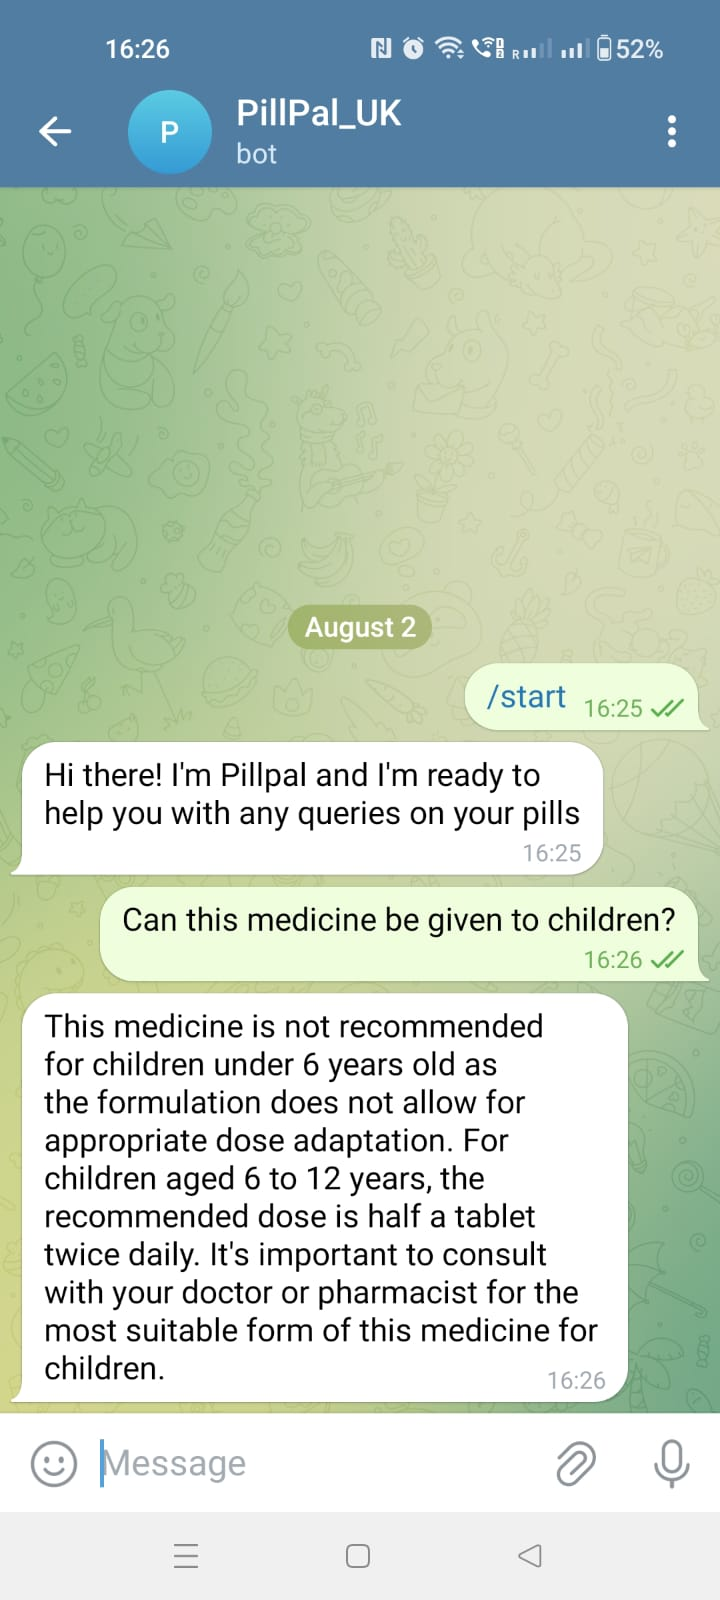

## Listening on **Codespaces**

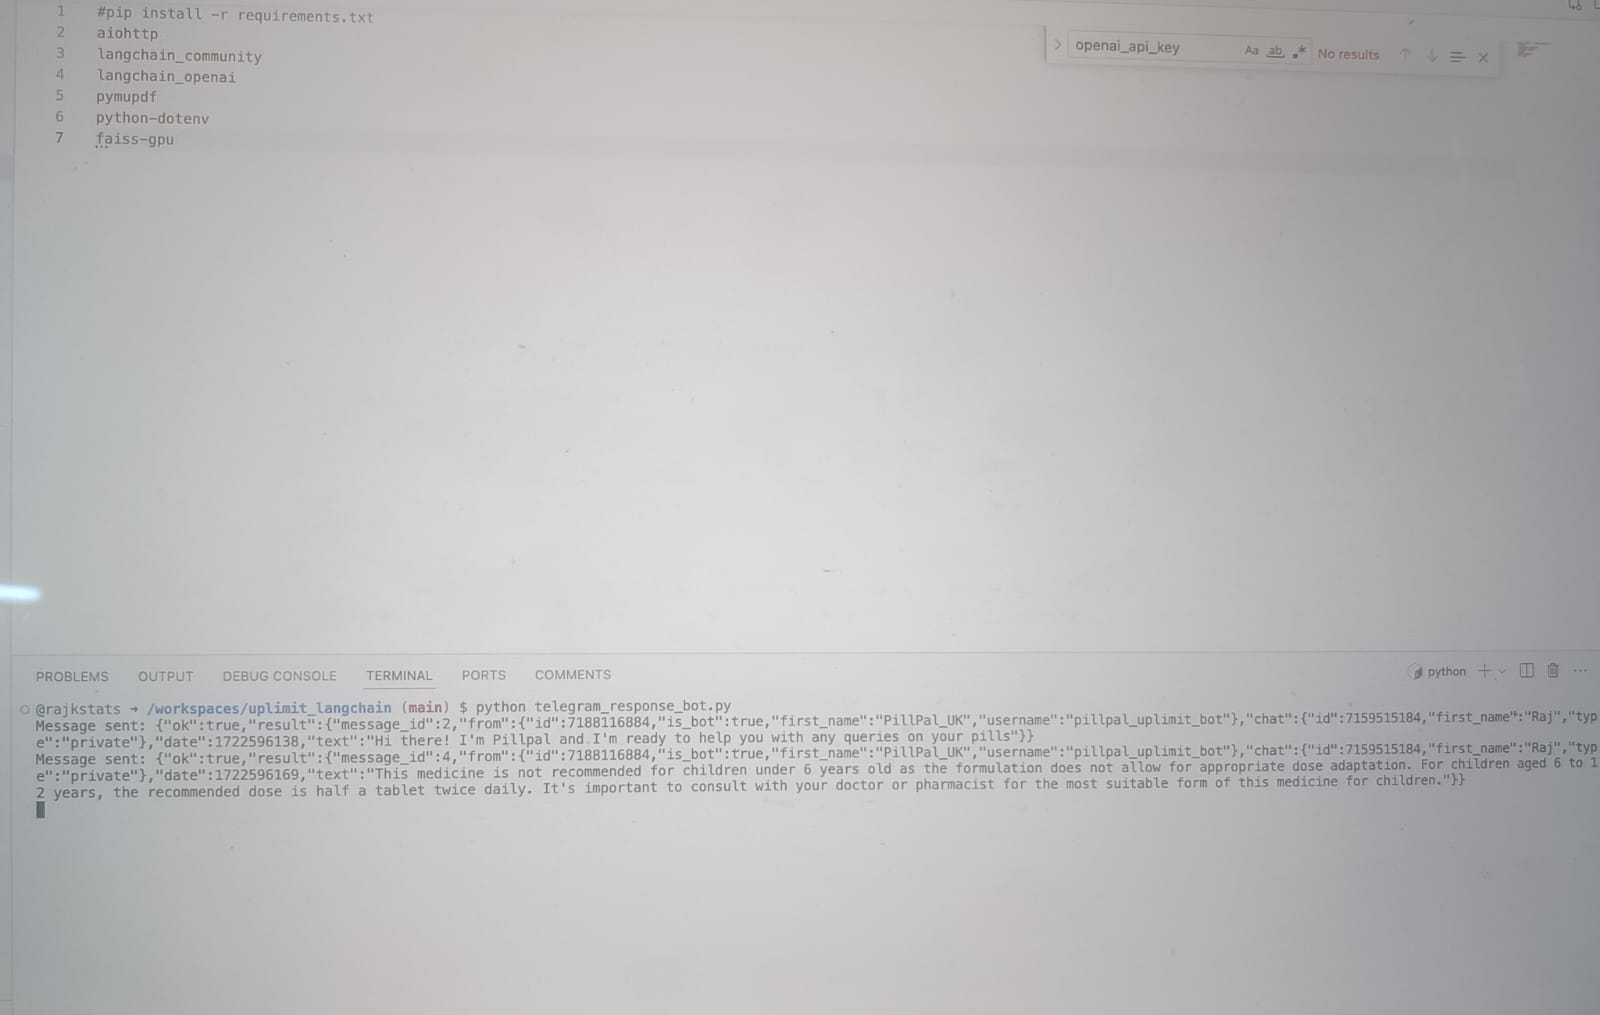

# Step 3: Evaluation of PillPal

Now that we have deployed and made our app live, we need to consistently monitor how it performs. This is also a way for us to understand what questions are being asked by our users and whether the bot is responding correctly or not. For this we will make use of the Langsmith part of the Langchain library.

As the first step, we have to create a validation dataset that we can use for evaluation. There are several ways to go about doing this:

1. Launch your app in beta and get some trial users to start interacting with the bot/chat interface and identify common patterns and questions that are being asked. Manually, write your own answers to these questions and perform evaluations using that.
2. Come up with a list of 5-10 questions and manually search for the answers of these questions in the PDF and create this as your evaluation dataset -> this is what we are going to do below.  
3. You could also make use of another LLM to come up with these questions and answers which is called creating a synthetic dataset. This would work well if you use higher level models like GPT-4 but you need to keep in mind that they have to be relevant to the context of your leaflet.

### Creating a base evaluation dataset

To ensure that our application is functioning correctly and effectively answering questions, we have implemented a basic sanity check. This involves a set of 8-10 questions that I have manually curated and answered after thoroughly reviewing the content of the PDF document. These questions are designed to cover a wide range of topics and complexities within the document, ensuring that they test various aspects of our QnA bot's capabilities. By comparing the answers generated by our bot to these manually prepared responses, we can gauge the accuracy and reliability of our system. This step is crucial as it helps us identify any discrepancies or areas needing improvement before the application is deployed for wider use. Additionally, it provides an initial layer of validation and builds confidence in the application's performance among users and stakeholders.

## 📝 Learner Task:

Please create a set of question and correct answer pairs here to use as your evaluation dataset. We have provided the first two questions as examples but feel free to overwrite and add your own.

In [18]:
examples = [
    (
        "Can it be taken by pregnant women?",
        "No, it should not be taken by pregnant women before seeking the doctors advice.",
    ),
    (
        "Can it be given to children?",
        "No, it should be taken by children aged less than 6 years old. Children above the age of 6 must follow the prescribed dosage - half a tablet twice daily for children between 6 and 12 years.",
    ),
    (
        "Is it safe to drive after taking Cetirizine Hydrochloride Tablets?",
        "Clinical studies have produced no evidence of impaired attention, alertness and driving capabilities after taking Cetirizine Hydrochloride Tablets at the recommended dose. However, you should closely observe your response to the drug if you are intending to drive or operate machinery.",
    ),
    (
      "What should you do if you take more Cetirizine Hydrochloride Tablets than you should?",
      "If you think you have taken an overdose of Cetirizine Hydrochloride Tablets, you should inform your doctor immediately. Your doctor will then decide what measures, if any, should be taken.",
    ),
    (
      "What should you do if you forget to take a dose?",
      "If you forget to take a tablet, you should take one as soon as you remember, but wait at least 24 hours before taking your next tablet. Do not take a double dose to make up for a forgotten dose.",
    ),
    (
      "What is the recommended dose for adults and children over 12 years?",
      "The recommended dose for adults and children 12 years and over is 10 mg once daily as one tablet daily.",
    ),
    (
    "Can Cetirizine Hydrochloride Tablets be given to children under 6 years old?",
    "No, the use of Cetirizine Hydrochloride Tablets is not recommended in children aged less than 6 years since this formulation does not allow for appropriate dose adaptation.",
    ),
]

Once we have successfully created our dataset, the next step involves registering it with the Langsmith client. This process integrates the dataset into our evaluation framework. By registering the dataset, we effectively add it to the list of datasets available for testing and validating our model. In general, you might create multiple datasets to test various aspects of the QnA bot and might run different types of evaluations on it.

In this case, we are running a test for general correctness of the QnA bot - while this does include checks for hallucinations -> we have added examples where the bot should not have an answer and must say so. But there are additional datasets that you might create with separate evaluation metrics to explicitly check for hallucination and fact-checking.

In [19]:
from langsmith import Client

client = Client()

In [20]:
import uuid
from langsmith import schemas as ls_schemas

dataset_name = f"PillPal QA {str(uuid.uuid4())}"
dataset = client.create_dataset(dataset_name=dataset_name, data_type=ls_schemas.DataType.llm)
for q, a in examples:
    client.create_example(
        inputs={"input": q}, outputs={"output": a}, dataset_id=dataset.id
    )

Once the above cells are run, you should now be able to see the dataset created in the dataset folder in your Langsmith project.

![QA Dataset](https://i.ibb.co/sH5dv86/Xnapper-2024-06-11-20-58-53.png)

Let's run the evaluation of our app using this dataset.

By executing the code below, we will first be calling our app for each of the questions in our QA dataset. Once the answers have been generated, we need to evaluate it with the golden standard answers that we have written manually. But the big question is always: how can we compare two texts, what metrics shall we use?

One of the easier ways to do this is by using another LLM to compare the two responses and tell you whether they match or not. This is also referred to as 'LLM-as-a-judge'. In this case, since we have only 5-10 examples you can easily do this manually but typically your evaluation datasets will contain a lot of examples and this method would not work.

We will use the off-the-shelf QA evaluator that Langsmith provides us. Under the hood, it creates a system prompt and desired response automatically for us and we can pick which LLM we would to use as our judge. Typically we make use of a bigger, more powerful LLM to act as the judge for what the smaller, cheaper LLM has generated.

In [21]:
from langchain.smith import RunEvalConfig
from langchain_openai import ChatOpenAI

eval_config = RunEvalConfig(
    evaluators=["qa"],
    eval_llm=ChatOpenAI(model_name="gpt-4", openai_api_key=openai.api_key)
)

Let's run the evaluation on the dataset. You get the links to where you can track the run and at the end the output is also printed here.

In [22]:
client.run_on_dataset(
    dataset_name=dataset_name,
    llm_or_chain_factory=lambda: rag_chain,
    evaluation=eval_config,
)

View the evaluation results for project 'pertinent-artist-3' at:
https://smith.langchain.com/o/bbdaa341-a469-5436-ba9e-24733ea4fe6d/datasets/858953d3-312b-4938-9057-a8d7d7d71d35/compare?selectedSessions=60c2de95-dc2e-4a98-9bdc-9e0983469830

View all tests for Dataset PillPal QA a1b19a87-91ff-4a48-8b40-0b34d4dfd298 at:
https://smith.langchain.com/o/bbdaa341-a469-5436-ba9e-24733ea4fe6d/datasets/858953d3-312b-4938-9057-a8d7d7d71d35
[------------------------------------------------->] 7/7

{'project_name': 'pertinent-artist-3',
 'results': {'98f1aa9a-f00b-45d2-a4aa-5d371ddb0ffb': {'input': {'input': 'Can Cetirizine Hydrochloride Tablets be given to children under 6 years old?'},
   'feedback': [EvaluationResult(key='correctness', score=1, value='CORRECT', comment='CORRECT', correction=None, evaluator_info={'__run': RunInfo(run_id=UUID('21ff099e-ccc9-4166-90b7-e5d6d9c8feae'))}, feedback_config=None, source_run_id=None, target_run_id=None)],
   'execution_time': 2.091289,
   'run_id': '54828cc0-8afd-4451-ad0e-067361fdda8d',
   'output': 'Cetirizine Hydrochloride Tablets should not be given to children under 6 years old because the formulation does not allow for appropriate dose adaptation in that age group. It is important to consult with a doctor for advice on suitable medications for children.',
   'reference': {'output': 'No, the use of Cetirizine Hydrochloride Tablets is not recommended in children aged less than 6 years since this formulation does not allow for approp

After initiating the evaluation of our QnA bot using the dataset we registered, you will be able to observe several key performance metrics. These metrics include the percentage of questions answered correctly, which provides a direct measure of the bot's accuracy. You will also see the duration of the test, which gives insight into the efficiency of the bot under testing conditions. Additionally, the evaluation will report on costs and latency, offering a broader view of the bot's operational performance.

This initial evaluation serves as a preliminary indication of how well your bot is performing. As the bot encounters more users and a diverse array of questions, it's crucial to continually update and adapt your baseline test dataset. This iterative process ensures that the bot remains effective and responsive to the evolving needs and contexts it will encounter in real-world applications.

![Evaluation Test results](https://i.ibb.co/txtzhtD/Xnapper-2024-06-16-11-32-28.png)

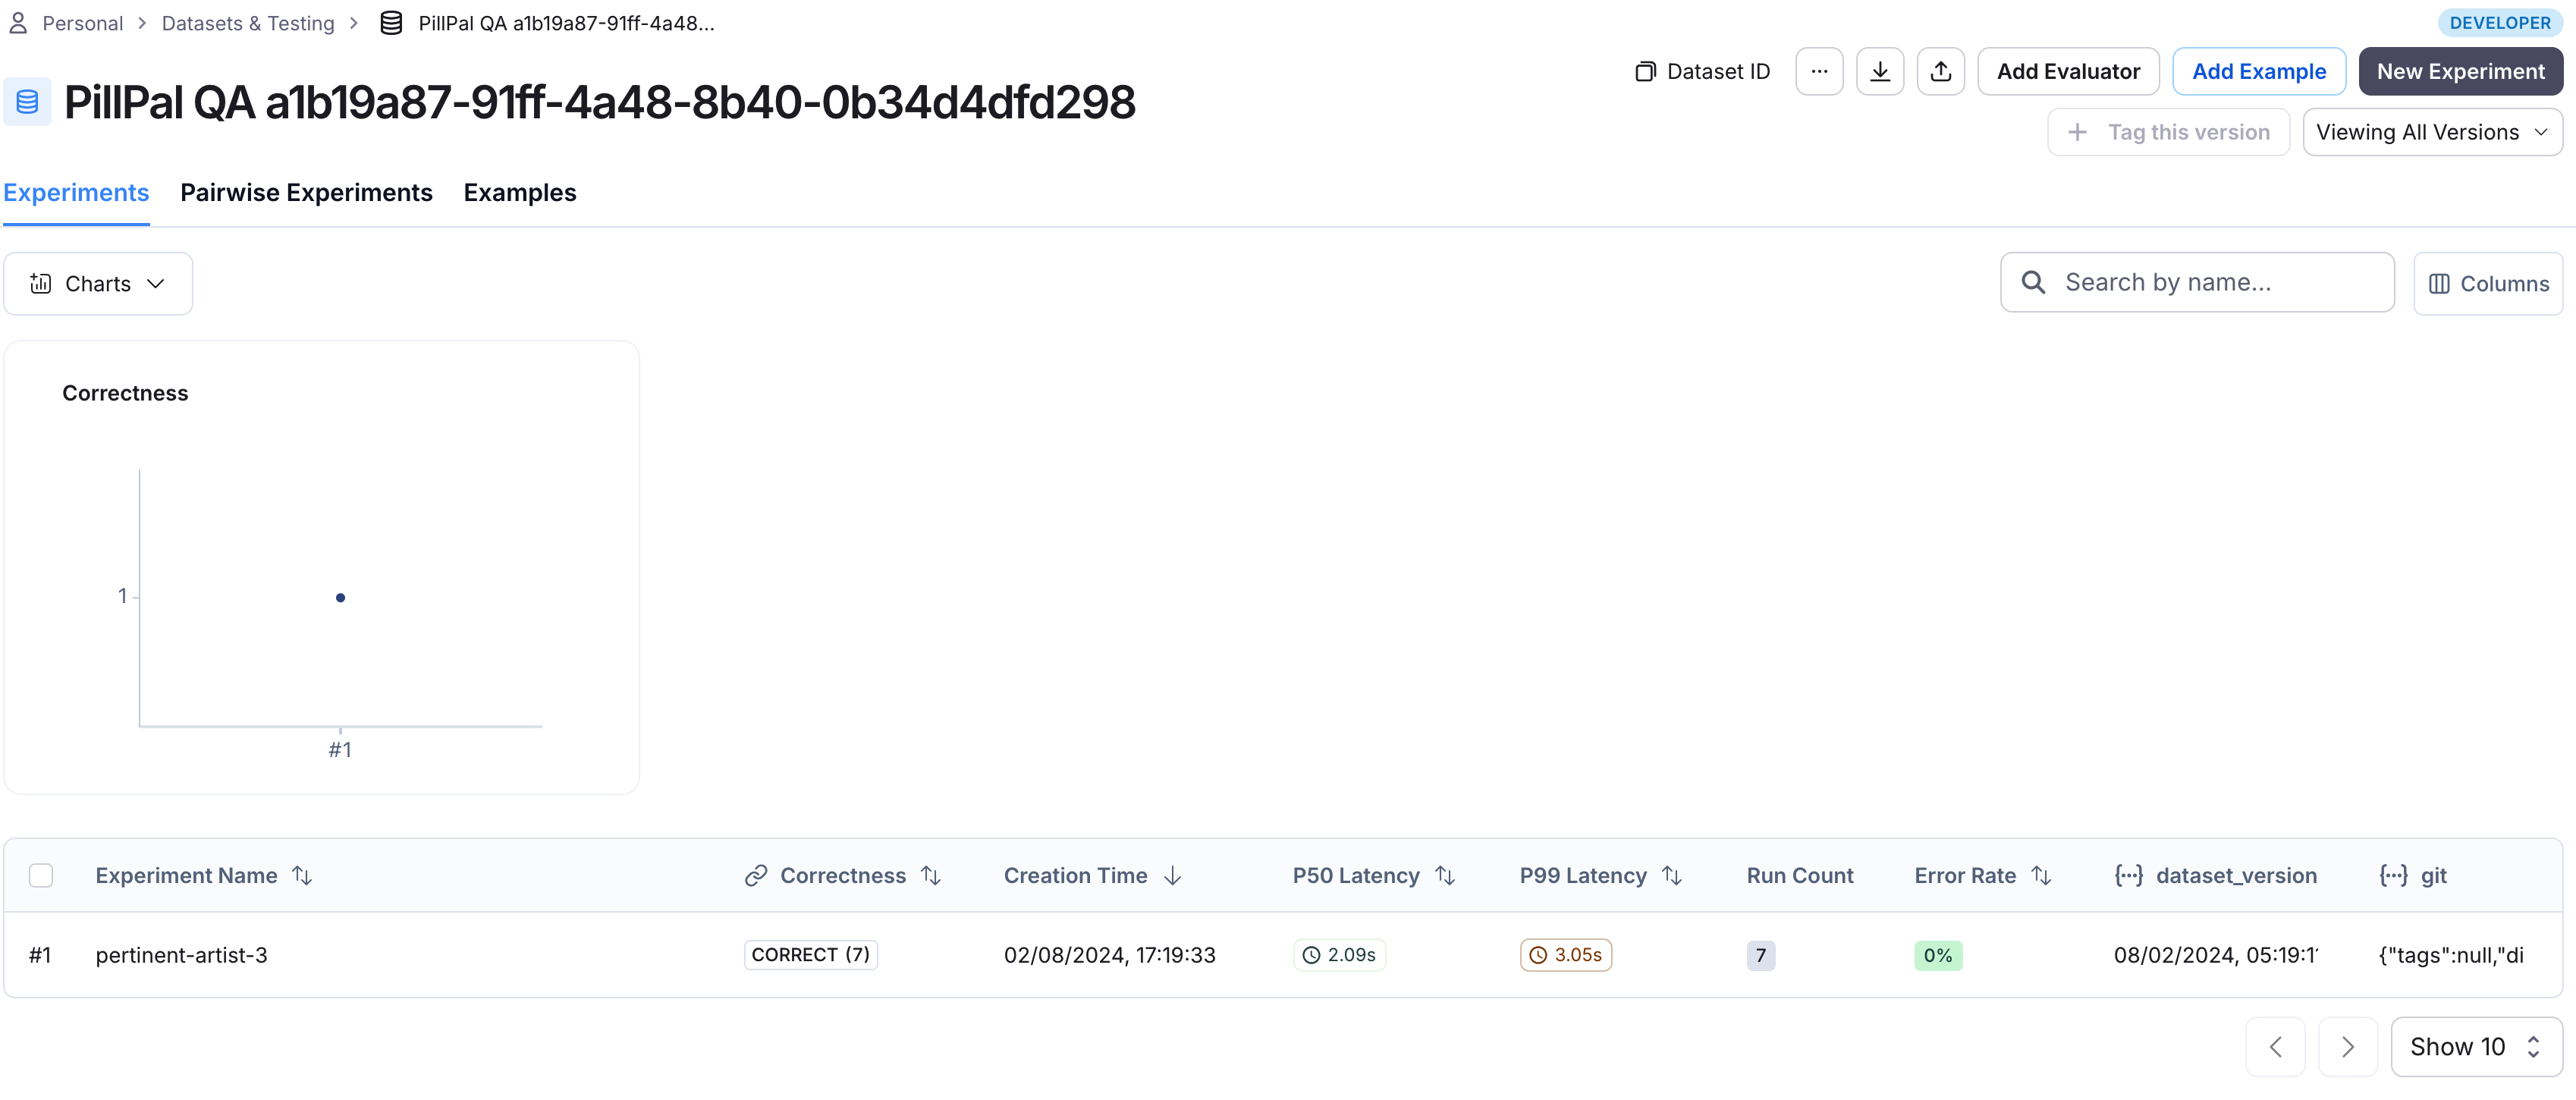

## 📝 Learner Task:

Now that you have an end to end RAG chatbot up and running, you can try to stress-test your bot by asking all kinds of questions - both relevant and irrelevant. What kind of responses does it generate? How often does it hallucinate?

## Relevant Questions

In [23]:
question = "What is the recommended dosage for adults?"
rag_chain.invoke({"input": question})

"For adults, the recommended dosage of Cetirizine Hydrochloride Tablets is 10 mg once daily as one tablet daily. If the tablets make you feel drowsy or dizzy, taking half a tablet twice a day may be better than taking one tablet once a day. It's important to consult your doctor if you feel that the effect of the medication is too weak or too strong. If you have renal impairment, the recommended dose may be adjusted. It's always best to follow your doctor's advice regarding dosage adjustments based on your individual needs."

In [24]:
question = "What should I do if I forget to take a dose?"
rag_chain.invoke({"input": question})

"If you forget to take a dose of Cetirizine Hydrochloride Tablets, do not take a double dose to make up for it. Instead, take the missed dose as soon as you remember, but wait at least 24 hours before taking your next tablet. It's important to follow this guidance to avoid any potential complications. If you have any further questions or concerns about your medication, it's best to consult your doctor or pharmacist for advice."

## Irrelevant Questions

In [25]:
question = "What's the capital of France?"
rag_chain.invoke({"input": question})

"I'm sorry, but the information provided does not contain the answer to your question about the capital of France. If you have any other questions or need assistance with something else, feel free to ask!"

In [26]:
question = "Who won the T20 Cricket World Cup in 2024?"
rag_chain.invoke({"input": question})

"I'm sorry, I don't have enough information to provide an answer to your question about who won the T20 Cricket World Cup in 2024. If you have any other questions or need assistance with something else, feel free to ask!"

## Some Edge Cases

In [28]:
question = "Is it safe to take Cetirizine Hydrochloride Tablets with apple juice?"
rag_chain.invoke({"input": question})

"It is generally safe to take Cetirizine Hydrochloride Tablets with apple juice as food does not affect the absorption of the medication. However, it's always best to consult with your doctor or pharmacist before combining any medication with other substances, including apple juice, to ensure there are no specific interactions that may affect the effectiveness of the medication."

## Tests for Hallucinations

In [29]:
question = "What flavor is the Cetirizine Hydrochloride Tablet?"
rag_chain.invoke({"input": question})

'The Cetirizine Hydrochloride Tablets are white circular bi-convex, film-coated tablets. They are marked with a "C" on one side and have a breakline on the other. The tablets do not have a specific flavor mentioned in the leaflet. Each tablet contains 10mg of cetirizine hydrochloride along with other ingredients like lactose, microcrystalline cellulose, maize starch, and more. The tablets are available in different pack sizes containing 7, 14, 21, 28, 30, or 60 tablets.'

In [30]:
question = "Can I use this medication to treat pet dog allergies?"
rag_chain.invoke({"input": question})

"I'm sorry, but based on the information provided, Cetirizine Hydrochloride Tablets are specifically indicated for the relief of symptoms of hayfever and other allergic conditions in adults and children over 6 years of age. It is not recommended for use in pets, such as dogs, to treat allergies. If you have any further questions about using this medication, it's best to consult your veterinarian for advice on treating your pet's allergies."

**What kind of responses does it generate?**
- After testing bot with various questions, I observed that it generally provides accurate responses that closely match the information in the leaflet. Answers are typically relevant and on-topic for questions about dosage, side effects, and usage instructions. It maintains consistency when asked similar questions multiple times.

**How often does it hallucinate?**
- Since bot provides answers to these questions expressing uncertainty or stating the information is not available, it may not be hallucinating